<a href="https://colab.research.google.com/github/kajastalder/data-science-fundamentals/blob/main/Coding_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coding Task 1

- Deadline: Send your solution notebook per email to Sigve by 2022-03-22 17:00
- Estimated effort: 2-5 hours (if you don't progress after 2 hours of trying, search for help, ChatGPT, Google, colleagues, course tutor)
- Data on Ilias: CCD-Data with metadata file CCD-Metadata


## Tasks (maximum 12.5 points)

- **CT-1.1** Write a method (function) which removes the header information in the 
datafile and saves that information into a separate textfile. [0.5 points] 
- **CT-1.2** Write a function which reduces the data resolution by merging/averaging columns such that there is only one column per 1 nm. [2.0 points]  
- **CT-1.3** Now generalize the above merging so that it works for any number nm er column. [2.0 points]
- **CT-1.4** Implement the saving of the reduced dataset to a file. Do this (1) by writing an explicit loop (write line by line) and (2) by using pandas methods. Measure the running times of the two approaches. [2.0 points]
- **CT-1.5** Write a function which takes two wavelengths as input and plots the difference of the data at these lengths over time. [2.0 points] 
- **CT-1.6** Let the x-axis be in seconds, label the axes with names and units, label the plot with color and legend, make a title for the plot. Save the plot to a file. [2.0 points]
- **CT-1.7** Plot the full and some reduced datasets in the same figure. Is there any visual difference? [2.0 points]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import timeit
from google.colab import drive

drive.mount('/content/drive')
path_google_drive = '/content/drive/MyDrive/DSF/'
file_name = 'CCD-Data'
path_original_file = path_google_drive + file_name + '.txt'


# remove the header of the file with path 'path'

def remove_header(path):
  # find length of header: call 'find_length_header' function
  length_header = find_length_header(path)
  # create new text file containing only data without header
  path_new_file = path_google_drive + file_name + '-without-header.txt'
  with open(path, 'r') as input_file:
    with open(path_new_file, 'w') as output_file:
      line_nr = -1
      for line in input_file:
        line_nr += 1
        if line_nr > length_header:
          output_file.write(line)
  return path_new_file
  

# find the length of the header        
def find_length_header(path):
  pattern = r'>'
  lines = []
  nr = -1
  with open (path, 'r') as f:
    for line in f:
      nr += 1
      result = re.findall(pattern, line)
      if result:
        lines.append(nr)
  return lines[-1]


# reduce data resolution
def reduce_data_resolution(resolution, file_path):
  # get list of wavelengths that we wanna keep
  df = pd.read_csv(file_path, delimiter='\t')
  wavelengths = df.columns
  current_wl = 0
  wl_list = ['Unnamed: 0', 'Unnamed: 1']
  for i in range(2, len(wavelengths)):
    wl = float(wavelengths[i])
    if wl > current_wl + resolution:
      wl_list.append(str(wl))
      current_wl = wl
  # get sub-array containing only those wavelengths
  return df.loc[:,wl_list]
  


# save new dataframe to file using loop:
# adds an additional column due to tab stop after last item and value
def save_df_to_file_loop(df):
  new_path = path_google_drive + file_name + '-reduced-resolution-loop.txt'
  with open(new_path, 'w') as f:
    for item in df:
      f.write(item+'\t')
    for i in range(0, (len(df))):
      f.write('\n')
      for j in range(0, (len(df.columns))):
        value = str(df.iloc[i, j])
        f.write(value+'\t')
    return new_path


def save_df_to_file_pandas(df):
  new_path = path_google_drive + file_name + '-reduced-resolution-pandas.txt'
  df.to_csv(new_path, sep='\t') 
  return new_path

# plot absorbance over time at two wavelengths of interest to compare them
def plot_two_wavelengths(wl1, wl2, df):
  #get x_vals: seconds since start measurement
  x_vals = get_x_vals(df)
  #get y_vals: corresponding adsorption values
  y_vals_wl1 = get_y_vals_wl(df, wl1)
  y_vals_wl2 = get_y_vals_wl(df, wl2)
  # plot values
  fig, ax = plt.subplots()
  ax.plot(x_vals, y_vals_wl1, color='b', label=wl1+' nm')
  ax.plot(x_vals, y_vals_wl2, color='g', label=wl2+' nm')
  # make nice-looking plot out of it
  plt.title('Absorbance at two wavelengths over time:')
  plt.xlabel('Seconds (s)')
  plt.ylabel('Absorbance (A)')
  plt.legend()
  # save plot to file
  path = path_google_drive + file_name + '-absorbance-at-two-wl-over-time.pdf'
  plt.savefig(path)


#get seconds out of 2018-10-25 10:32:04.789000 (column 'Unnamed: 0')
#save them in list x_vals
def get_x_vals(df):
  timepoint_list = df['Unnamed: 0'].tolist()
  seconds = []
  pattern = f'\d\d\.\d+'
  for item in timepoint_list:
    value = re.findall(pattern, item)
    seconds.append(value[0])
  x_vals = []
  for item in seconds:
    x_val = float(item) - float(seconds[0])
    x_vals.append(x_val)
  return x_vals

# get adsorbance values of a defined column (with wl) in a list
def get_y_vals_wl(df, wl):
  adsorbance_list = df[wl].tolist()
  return adsorbance_list


# plot whole data of one or two dataframes
def plot_dataframes(df1, df2=None):
  fig, ax = plt.subplots()
  #get x_vals: seconds since start measurement
  x_vals = get_x_vals(df1)
  #get y_vals: corresponding adsorption values
  for wl in df1.columns.values[2:]:
    y_vals_1 = get_y_vals_wl(df1, wl)
    # plot values
    ax.plot(x_vals, y_vals_1, '.')
  if df2 is not None:
    for wl in df2.columns.values[2:]:
      y_vals_2 = get_y_vals_wl(df2, wl)
      # plot values
      ax.plot(x_vals, y_vals_2, '.') 
  # make nice-looking plot out of it
  plt.title('Absorbance at different wavelengths over time:')
  plt.xlabel('Seconds (s)')
  plt.ylabel('Absorbance (A)')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# remove header, get path of file without header
path_file_without_header = remove_header(path_original_file)
df_without_header = pd.read_csv(path_file_without_header, delimiter='\t')

# reduce data resolution: only wavelengths that are at least input nm appart
# remaining data is saved in new data frame (df_reduced_resolution)
resolution_in_nm = float(input('Resolution in nm:'))
df_reduced_resolution = reduce_data_resolution(resolution_in_nm, path_file_without_header)


Resolution in nm:10


In [ ]:
%%timeit -n 100 -r 5
# save the reduced df in a file using a loop
# measure required execution time
path_file_from_loop = save_df_to_file_loop(df_reduced_resolution) 


70.9 ms ± 4.28 ms per loop (mean ± std. dev. of 5 runs, 100 loops each)


In [ ]:
%%timeit -n 100 -r 5
# save the reduced df in a file using pandas method
# measure required execution time
path_file_pandas = save_df_to_file_pandas(df_reduced_resolution)

26.8 ms ± 4.89 ms per loop (mean ± std. dev. of 5 runs, 100 loops each)


In [65]:
#plot absorbance over time at two wavelengths
wl1 = input('First wavelength of interest:')
wl2 = input('Second wavelength of interest:')

try:
  wl_list = list(df_without_header.columns.values[2:])
  wl_list.index(wl1)
  wl_list.index(wl2)
  plot_two_wavelengths(wl1, wl2, df_without_header)
except:
  print('''One of the indicated wavelengths doesn't exist. You have to rerun the cell.''' )


First wavelength of interest:6
Second wavelength of interest:8
One of the indicated wavelengths doesn't exist. You have to rerun the cell.


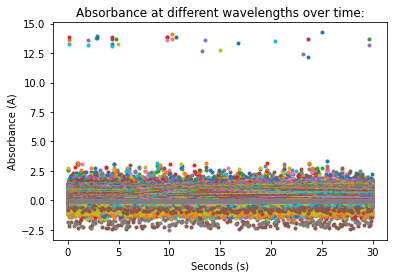

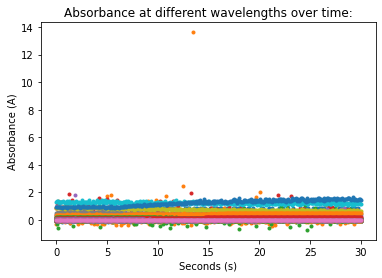

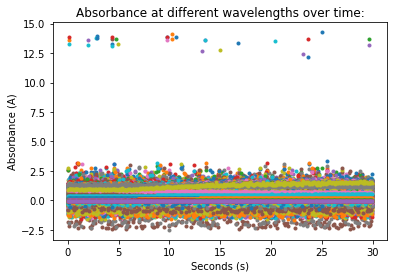

In [ ]:
# plot complete data file
plot_dataframes(df_without_header)

# plot reduced df
plot_dataframes(df_reduced_resolution)

# plot both dataframes in the same plot
plot_dataframes(df_without_header, df_reduced_resolution)